In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import sys

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from torch.utils.data import DataLoader, TensorDataset
from itertools import islice


# Process Datasets

In [2]:
def Process_dataset (file, Away):
    df = pd.read_csv(file, skiprows = [0,1])
    df = df.iloc[::25]
    
    for index, line in enumerate(df.iterrows()):
        row_tensor = torch.tensor(df.iloc[index, :25].values)
        out_player = torch.where(torch.isnan(row_tensor))[0]
        out_player = df.columns[out_player]    
        sub_players = df.iloc[index, 25:df.shape[1]-2]
        in_player =  sub_players.index[sub_players.notnull()]
        subset_df = df.iloc[index:, :]
        if  not out_player.empty:
            #print(line)
            print(out_player[0], " replaced by ", in_player[0], " at time [s] : ", df.iloc[index,2])
            in_player_index_label = in_player[0]
            out_player_index_label = out_player[0]
            subset_df = df.iloc[index:, :].copy()
            subset_df[in_player_index_label], subset_df[out_player_index_label] = subset_df[out_player_index_label].values, subset_df[in_player_index_label].values
            df.iloc[index:, :] = subset_df
    
            in_player_index_label = in_player[1]
            out_player_index_label = out_player[1]
            subset_df = df.iloc[index:, :].copy()
            subset_df[in_player_index_label], subset_df[out_player_index_label] = subset_df[out_player_index_label].values, subset_df[in_player_index_label].values
            df.iloc[index:, :] = subset_df
    
    
    df = df.interpolate(method='linear', axis=0, limit_direction='both')
    df = df.dropna(axis=1)

    
    
    
    concatenated_df = pd.DataFrame()
    
    # Iterate over pairs of columns and concatenate them into a new column of vector entries
    for i in range(3, len(df.columns) - 1, 2):
        column1 = df.columns[i]
        column2 = df.columns[i + 1]
        if Away:
            new_column_name = f'Player_{int(i/2)+11}'
        else:
            new_column_name = f'Player_{int(i/2)}'
        if i == 25:
            new_column_name = "Ball"
        concatenated_column = df[[column1, column2]].apply(lambda x: torch.tensor(x.values.tolist()), axis=1)
        concatenated_df[new_column_name] = concatenated_column
    
    first_3_columns = df.iloc[:, :3]
    df = pd.concat([first_3_columns, concatenated_df ], axis=1)
    
    return df

In [3]:

Home_team = Process_dataset('C:/Users/user/Notebooks/Soccer Valuation/Sample_Game_1_RawTrackingData_Home_Team.csv', Away = False)
Away_team = Process_dataset('C:/Users/user/Notebooks/Soccer Valuation/Sample_Game_1_RawTrackingData_Away_Team.csv', Away = True)
home_team_subset = Home_team.iloc[:, :-1]
away_team_subset = Away_team.iloc[:, 3:]
Game_dataset = pd.concat([home_team_subset, away_team_subset], axis=1)
Game_dataset.reset_index(drop=True, inplace=True)

exclude_columns = ['Period', 'Frame', 'Time [s]']
for index, row in Game_dataset.iterrows():
    seen_values = []
    for column, value in row.items():
        if column not in exclude_columns:
            #Multiply by football width and length
            Game_dataset.at[index, column] *= torch.tensor([105,68])
            
            #Switch coordinates for second half time
            if Game_dataset.iloc[index,0]==2:
                pos_x = Game_dataset.at[index,column][0]
                Game_dataset.at[index,column][0] = 105 - pos_x

            #Assure nobody is at the same place
            for seen in seen_values:
                if seen[0]==value[0]:
                    value[0]+=0.0001
                if seen[1]==value[1]:
                    value[1]+=0.0001
                Game_dataset.at[index, column] = value
            seen_values.append(value)
                    
           
                
Game_dataset.to_csv('C:/Users/user/Notebooks/Soccer Valuation/game_1.csv', index=False) 

#Game_dataset =  pd.read_csv('C:/Users/user/Notebooks/Soccer Valuation/game_1.csv')

Game_dataset.head()

Player1  replaced by  Player12  at time [s] :  1869.04
Player6  replaced by  Player13  at time [s] :  4434.04
Player10  replaced by  Player14  at time [s] :  4856.04
Player24  replaced by  Player26  at time [s] :  4264.04
Player22  replaced by  Player27  at time [s] :  4275.04
Player19  replaced by  Player28  at time [s] :  4776.04


,Period,Frame,Time [s],Player_1,Player_2,Player_3,Player_4,Player_5,Player_6,Player_7,...,Player_14,Player_15,Player_16,Player_17,Player_18,Player_19,Player_20,Player_21,Player_22,Ball
0,1,1,0.04,"[tensor(0.0861), tensor(32.8018)]","[tensor(34.2804), tensor(44.4190)]","[tensor(35.3861), tensor(33.2268)]","[tensor(32.4734), tensor(24.1597)]","[tensor(33.7439), tensor(14.4582)]","[tensor(43.1487), tensor(49.3605)]","[tensor(43.7829), tensor(32.5332)]",...,"[tensor(71.0409), tensor(31.7628)]","[tensor(70.6755), tensor(52.0037)]","[tensor(42.8222), tensor(41.8370)]","[tensor(47.7456), tensor(26.3221)]","[tensor(58.7580), tensor(46.0870)]","[tensor(58.0052), tensor(29.4230)]","[tensor(52.5704), tensor(64.1390)]","[tensor(45.8777), tensor(3.4014)]","[tensor(39.7246), tensor(18.6204)]","[tensor(47.7457), tensor(26.3222)]"
1,1,26,1.04,"[tensor(0.0672), tensor(32.7298)]","[tensor(34.0053), tensor(42.3082)]","[tensor(34.9282), tensor(32.3877)]","[tensor(33.0886), tensor(23.1520)]","[tensor(34.0358), tensor(12.4488)]","[tensor(43.4196), tensor(47.1981)]","[tensor(43.0605), tensor(30.6714)]",...,"[tensor(69.8502), tensor(30.4456)]","[tensor(68.8664), tensor(50.0827)]","[tensor(41.2766), tensor(39.2986)]","[tensor(47.0505), tensor(23.6205)]","[tensor(59.4289), tensor(43.0080)]","[tensor(55.8253), tensor(28.5512)]","[tensor(51.5676), tensor(63.5406)]","[tensor(43.8795), tensor(2.0291)]","[tensor(37.0839), tensor(19.8975)]","[tensor(59.5413), tensor(13.5334)]"
2,1,51,2.04,"[tensor(-0.0210), tensor(32.6577)]","[tensor(33.4646), tensor(39.6528)]","[tensor(34.3529), tensor(31.3099)]","[tensor(33.1832), tensor(22.3808)]","[tensor(33.2734), tensor(11.1534)]","[tensor(43.5435), tensor(44.7243)]","[tensor(43.0437), tensor(28.7300)]",...,"[tensor(68.1744), tensor(28.5518)]","[tensor(66.3212), tensor(46.9023)]","[tensor(39.0674), tensor(36.5888)]","[tensor(47.0662), tensor(21.1562)]","[tensor(58.9995), tensor(38.8470)]","[tensor(52.9242), tensor(28.3696)]","[tensor(49.6461), tensor(63.0251)]","[tensor(41.2598), tensor(1.4430)]","[tensor(35.0049), tensor(21.4622)]","[tensor(53.9280), tensor(15.7359)]"
3,1,76,3.04,"[tensor(0.1019), tensor(32.6890)]","[tensor(33.4981), tensor(38.0059)]","[tensor(34.3759), tensor(31.4452)]","[tensor(33.3091), tensor(23.5430)]","[tensor(32.5343), tensor(11.8245)]","[tensor(43.3020), tensor(43.0658)]","[tensor(43.5771), tensor(27.9997)]",...,"[tensor(65.7773), tensor(27.2598)]","[tensor(63.3581), tensor(44.6950)]","[tensor(37.9008), tensor(35.0139)]","[tensor(47.5387), tensor(21.5308)]","[tensor(57.1210), tensor(35.6000)]","[tensor(51.2400), tensor(29.8153)]","[tensor(47.0516), tensor(63.1407)]","[tensor(38.6022), tensor(2.3290)]","[tensor(34.5660), tensor(23.4756)]","[tensor(47.5209), tensor(21.4574)]"
4,1,101,4.04,"[tensor(0.7434), tensor(32.8012)]","[tensor(34.1355), tensor(39.0646)]","[tensor(34.6699), tensor(33.4438)]","[tensor(33.7407), tensor(25.8570)]","[tensor(33.2766), tensor(13.8428)]","[tensor(42.7760), tensor(43.6308)]","[tensor(42.5208), tensor(29.5732)]",...,"[tensor(64.1077), tensor(27.5386)]","[tensor(60.8895), tensor(45.6321)]","[tensor(37.8294), tensor(35.7394)]","[tensor(47.7519), tensor(23.7640)]","[tensor(55.0431), tensor(35.8680)]","[tensor(50.9534), tensor(32.9535)]","[tensor(43.5309), tensor(63.6664)]","[tensor(36.3227), tensor(4.4125)]","[tensor(35.2737), tensor(25.3218)]","[tensor(50.9628), tensor(32.7984)]"


# Create States

In [4]:
#Find the index of a player 1-22 for column between 3-24
def get_player_nb(player, df, t):
    index = 0
    for column in df.columns:
        if (df.iloc[t, index] == player).all():
            column_name = column
            if column_name == "Ball":
                return 23
            else:
                player_nb = int(column_name.split('_')[1])
            return player_nb
        index+=1


#Finds the most common composition in a list of Compositions
def most_common_element(lst):
    counts = {}  # Dictionary to store counts of each tensor
    max_count = 0
    most_common = None

    # Define a function to convert tensor to a hashable representation (tuple)
    def tensor_to_tuple(tensor):
        return tuple(tensor.flatten().tolist())

    # Iterate through the list and count occurrences of each tensor
    for tensor in lst:
        tensor_tuple = tensor_to_tuple(tensor)
        counts[tensor_tuple] = counts.get(tensor_tuple, 0) + 1
        if counts[tensor_tuple] > max_count:
            max_count = counts[tensor_tuple]
            most_common = tensor

    return most_common

#Gets the relative positions matrix given a list of players
def get_relative_positions(players, df, t):
    n = len(players)
    mat = torch.zeros(n,n)
    sorted_x = sorted(players, key=lambda x: x[0])
    sorted_y= sorted(players, key=lambda x: x[1])
    for player in players:
        i = [a for a, tensor in enumerate(sorted_y) if torch.all(torch.eq(tensor, player))][0]
        j = [a for a, tensor in enumerate(sorted_x) if torch.all(torch.eq(tensor, player))][0]
        player_nb = get_player_nb(player, df, t)
        mat[i][j] = player_nb
       
    return mat


def mirror_matrix(matrix):
    mirrored_matrix = []
    for row in matrix:
        mirrored_row = list(reversed(row))  # Reverse the order of columns in the row
        mirrored_matrix.append(mirrored_row)
    return mirrored_matrix

def switch_columns(tensor):
    # Get the number of columns in the tensor
    num_columns = tensor.shape[1]
    
    # Reverse the order of columns using torch.flip
    reversed_tensor = torch.flip(tensor, dims=[1])
    
    return reversed_tensor

    

# returns the list of compositions of the team 
def compute_compositions(team, df):
    if team == "Home":
        i  = 4
        j = 14
    else:
        i = 15
        j = 25
    
    Compositions = []
    for t in range(df.shape[0]):
        Team = df.iloc[t, i:j]
        Compositions.append(get_relative_positions(Team, df, t))
    return Compositions

In [5]:

Home  = Game_dataset.iloc[0, 3:14]
Away  = Game_dataset.iloc[0, 14:25]
Game =  Game_dataset.iloc[0, 3:26]
Compos_home = compute_compositions("Home", Game_dataset)
Compos_away = compute_compositions("Away", Game_dataset)
avg_compo_home = most_common_element(Compos_home)
avg_compo_away = most_common_element(Compos_away)
avg_compo_away = switch_columns(avg_compo_away)
avg_compo_ball = torch.full((1, 1), 23)
torch.save(avg_compo_home, 'avg_compo_home.pt')
torch.save(avg_compo_away, 'avg_compo_away.pt')

"""
avg_compo_home = torch.load('avg_compo_home.pt')
avg_compo_away = torch.load('avg_compo_away.pt')
"""

In [6]:
def place_in_compo(role):
    role = torch.floor((role/2).clone().detach().requires_grad_(True))
    i,j = role
    return int(5*j + i)+2

In [7]:
def get_features(player, df, relative_positions, t, Delta):

    player_nb = get_player_nb(player, df, t)
    
    #First get indexes of the relative positions : Index_Game   
    indexes = torch.where(relative_positions == player_nb)
    indexes = [int(indexes[0]), int(indexes[1])]
    

    # Now compute features
    
    #Team label
    if player_nb<=11:
        team_label = 1
        team = "home"
    elif player_nb<=22:
        team_label = -1
        team = "away"
    else:
        team_label = 23
        team = "ball"
    
    #Role_team
    role = [0,0]
    if player_nb % 11 != 1:     #If player is not a goal or ball
        r  = torch.where(globals().get(f"avg_compo_{team}") == player_nb)
        r = torch.floor(torch.tensor(r))
        r = [int(r[0]), int(r[1])]
        role = [int(r[0]/2), int(r[1]/2) ]

    #Position
    pos = df.iloc[t, player_nb+2]

    #Velocity
    vel = torch.tensor([0,0])
    if t>0:
         vel = (pos - df.iloc[t-1, player_nb+2]) / Delta

    #Acceleration
    acc = torch.tensor([0,0])
    if t>1:
        vel2 = (df.iloc[t-1, player_nb+2] - df.iloc[t-2, player_nb+2]) / Delta
        acc  = (vel - vel2) / Delta


    return indexes, team_label, role, pos, vel, acc



def get_state(df, avg_compo_home, avg_compo_away, t, Delta):

    # Initialize state matrices
    Mt = torch.zeros(23,23)
    Mr1 = torch.zeros(23,23)
    Mr2 = torch.zeros(23,23)
    Mp1 = torch.zeros(23,23)
    Mp2 = torch.zeros(23,23)
    Mv1 = torch.zeros(23,23)
    Mv2 = torch.zeros(23,23)
    Ma1 = torch.zeros(23,23)
    Ma2 = torch.zeros(23,23)

    Game =  df.iloc[t, 3:26]
    relative_positions = get_relative_positions(Game, df, t)

    for player in Game:
        indexes, team_label, role, pos, vel, acc = get_features(player, df, relative_positions, t, Delta)
        i,j = indexes
        Mt[i][j] = team_label
        Mr1[i][j] = role[0] 
        Mr2[i][j] = role[1] 
        Mp1[i][j] = pos[0].float() 
        Mp2[i][j] = pos[1].float() 
        Mv1[i][j] = vel[0].float() 
        Mv2[i][j] = vel[1].float() 
        Ma1[i][j] = acc[0].float() 
        Ma2[i][j] = acc[1].float() 
    
    state = torch.stack([Mt, Mr1, Mr2, Mp1, Mp2, Mv1, Mv2, Ma1, Ma2], axis=0)
    
    return state


In [8]:
#The states are already computed to save running time

#Compute the states
Delta = 1
Mt = np.zeros((23, 23))
Mr1 = np.zeros((23, 23))
Mr2 = np.zeros((23, 23))
Mp1 = np.zeros((23, 23))
Mp2 = np.zeros((23, 23))
Mv1 = np.zeros((23, 23))
Mv2 = np.zeros((23, 23))
Ma1 = np.zeros((23, 23))
Ma2 = np.zeros((23, 23))
state = np.stack([Mt,Mr1, Mr2, Mp1, Mp2, Mv1, Mv2, Ma1, Ma2], axis = 2)
States = []
for t in range(Game_dataset.shape[0]):
    percentage = t / len(Home_team) * 100
    sys.stdout.write("\rProgress: {:.2f}%".format(percentage))
    sys.stdout.flush()
    new_state = get_state(Game_dataset, avg_compo_home, avg_compo_away, t, Delta)
    States.append(new_state)
    state = new_state
States = torch.stack(States)
torch.save(States, 'States.pt')

"""
States = torch.load('States.pt')
"""

# Convolutional Autoencoder

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
         # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(9, 32, kernel_size=3, stride=1, padding=1),  # Input size: 9x23x23, Output size: 32x23x23
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Input size: 32x23x23, Output size: 64x23x23
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Input size: 64x23x23, Output size: 64x11x11
            nn.Flatten(),                                         # Flatten the output into a vector
            nn.Linear(64*11*11, 128),                             # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 10)                                    # Output layer with 10 units
        )

        
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),                       # Input size: 1x10, Output size: 1x128
            nn.ReLU(),
            nn.Linear(128, 64*11*11),                 # Fully connected layer to match desired shape
            nn.ReLU(),
            nn.Unflatten(1, (64, 11, 11)),            # Reshape the output into a 3D tensor: 64x11x11
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # Transposed convolutional layer: 32x23x23
            nn.ReLU(),
            nn.ConvTranspose2d(32, 9, kernel_size=3, stride=1, padding=0), # Transposed convolutional layer: 9x23x23
            nn.ReLU(),
            nn.ZeroPad2d((0, -1, 0, -1))  # Crop the output to match input size
        )        
        
        
        
    def encode(self, x):
        x = self.encoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [10]:
# Create DataLoader
batch_size = 32
loss_values = []
data_loader = DataLoader(States, batch_size=batch_size, shuffle=True)


# Initialize the Model   
model = ConvAutoencoder()
torch.save(model.state_dict(), 'CAE.pt')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
Encoded_States = []


# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    torch.save(model.state_dict(), 'CAE.pt')
    running_loss = 0.0
    # Inside the training loop
    for data in data_loader:
        optimizer.zero_grad()
        input_data = data.clone().detach().requires_grad_(True)
        data = data.clone().detach().requires_grad_(True)
        
        #save encoded states for the LSTM
        encoded =  model.encode(data)
        for d in encoded:
            Encoded_States.append(d)
            
        reconstructions= model(input_data)
        loss = criterion(reconstructions, input_data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_values.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_values[-1]}")

   
print('Finished Training')
torch.save(Encoded_States, 'Encoded_States.pt')





Epoch 1/15, Loss: 26.937856674194336
Epoch 2/15, Loss: 27.681028366088867
Epoch 3/15, Loss: 17.30931282043457
Epoch 4/15, Loss: 20.908790588378906
Epoch 5/15, Loss: 11.667226791381836
Epoch 6/15, Loss: 17.67526626586914
Epoch 7/15, Loss: 24.344846725463867
Epoch 8/15, Loss: 24.80988121032715
Epoch 9/15, Loss: 17.396352767944336
Epoch 10/15, Loss: 17.86636734008789
Epoch 11/15, Loss: 16.872100830078125
Epoch 12/15, Loss: 21.251331329345703
Epoch 13/15, Loss: 14.249773979187012
Epoch 14/15, Loss: 14.125611305236816
Epoch 15/15, Loss: 16.305950164794922
Finished Training


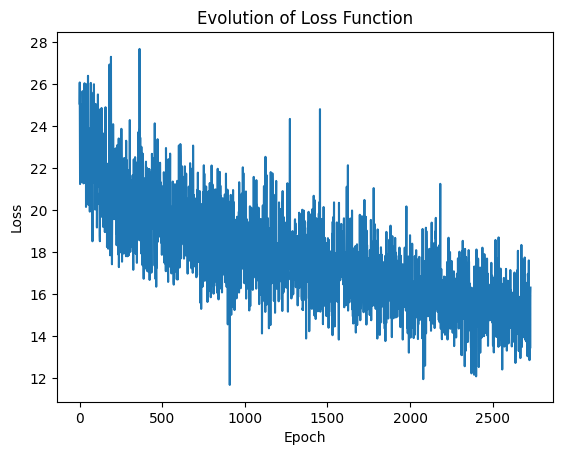

In [11]:
# Plot the evolution of the loss function
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss Function')
plt.show()


# LSTM

### Create Training and Test Datasets for the LSTM models


In [12]:
def shift_and_replace(matrix, new_row):
    n = matrix.shape[0]
    for i in range(n-1):
        matrix[i] = matrix[i+1]
    matrix[-1] = new_row
    return matrix

In [13]:
#Create Dataset
Datasets = []
Delta = 1
n = len(Home_team)
T = 10

for p in range(23):
    X = torch.zeros(n, 10, 17)
    Y = torch.zeros(n, 2)
    D = torch.zeros(10,17)
    for t in range(n):      
        players = Game_dataset.iloc[t, 3:26]
        relative_positions = get_relative_positions(players, Game_dataset, t)
        indexes =  torch.where(relative_positions == p+1)
        i = int(indexes[0].item())
        j = int(indexes[1].item())
        features = torch.tensor((States[t][0][i][j], States[t][3][i][j], States[t][4][i][j], States[t][5][i][j], States[t][6][i][j], States[t][7][i][j], States[t][8][i][j] ))
        input = torch.cat((features, Encoded_States[t]))
        D = shift_and_replace(D, input)
        X[int(torch.floor(torch.tensor(t)))] = D
        Y[int(torch.floor(torch.tensor(t)))] = torch.tensor((States[t][3][i][j], States[t][4][i][j]))
            
        sys.stdout.write("\rDataset {} / 23 created at {:.2f}%".format(p+1, t/n*100))
        sys.stdout.flush()
    Datasets.append([X,Y])
    



Dataset 23 / 23 created at 99.98%

In [14]:
# Define the percentage of data for training and testing
train_ratio = 0.8  

# Initialize lists to store the split datasets
split_datasets = []

# Loop over each dataset
for X, Y in Datasets:
    Y = shift_and_replace(Y, Y[-1])
    # Determine the number of samples for training and testing
    num_samples = X.size(0)
    num_train = int(train_ratio * num_samples)
    num_test = num_samples - num_train
    
    # Split the dataset into training and testing sets
    X_train, X_test = X[:num_train], X[num_train:]
    y_train, y_test = Y[:num_train], Y[num_train:]
    
    # Append the split dataset to the list
    split_datasets.append((X_train, y_train, X_test, y_test))

torch.save(split_datasets, 'split_datasets.pt')

### Initialize and train models

In [15]:
# Parameters
input_dim = 17
output_dim = 2
num_units = 512
epochs = 10
batch_size = 32
sequence_length = 10

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_units, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, num_units, batch_first=True) 
        self.fc = nn.Linear(num_units, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Initialize and save all models
for i in range(27):
    model = LSTMModel(input_dim, num_units, output_dim)
    torch.save(model.state_dict(), f'lstm_model_{i+1}.pt')

# Loop to train and evaluate models
for p, data in enumerate(split_datasets):
    X_train, y_train, X_test, y_test = data
    
    # Convert data to PyTorch tensors
    X_train_tensor = X_train.float().clone().detach().requires_grad_(True)
    y_train_tensor = y_train.float().clone().detach().requires_grad_(True)
    X_test_tensor = X_test.float().clone().detach().requires_grad_(True)
    y_test_tensor = y_test.float().clone().detach().requires_grad_(True)
    
    # Create DataLoader for training and testing
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

    # Find corresponding model
    team = "Ball"
    if p<= 10:
        team = "home"
    elif p<=21:
        team = "away"
        
    if team == "Ball":
        m = 27
    elif p%11 == 0:
        m = 1
    else:
        indexes =  torch.where(globals().get(f"avg_compo_{team}") == p+1)
        i,j = indexes
        i = int(i)
        j = int(j)
        role = torch.tensor(indexes)
        m = place_in_compo(role)

    # Load the model
    model = LSTMModel(input_dim, num_units, output_dim)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        # Step the learning rate scheduler
        scheduler.step()


    # Save the trained model
    torch.save(model.state_dict(), f'lstm_model_{m}.pt')

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    print(f"Model {m} - Test Loss: {test_loss:.4f}")

Model 1 - Test Loss: 0.7729
Model 15 - Test Loss: 1.6252
Model 3 - Test Loss: 1.5477
Model 4 - Test Loss: 1.2034
Model 11 - Test Loss: 2.7402
Model 17 - Test Loss: 1.8011
Model 9 - Test Loss: 1.7519
Model 12 - Test Loss: 1.4343
Model 21 - Test Loss: 1.9728
Model 23 - Test Loss: 1.5454
Model 25 - Test Loss: 2.8636
Model 1 - Test Loss: 0.7450
Model 5 - Test Loss: 1.9406
Model 4 - Test Loss: 0.9975
Model 11 - Test Loss: 2.3473
Model 20 - Test Loss: 2.4073
Model 13 - Test Loss: 1.6514
Model 7 - Test Loss: 1.4632
Model 21 - Test Loss: 1.9952
Model 12 - Test Loss: 1.9064
Model 24 - Test Loss: 1.0905
Model 23 - Test Loss: 2.1844
Model 27 - Test Loss: 23.0618


# Simulation

In [16]:
import matplotlib.patches as patches
from IPython.display import clear_output

def create_pitch (pitch_length, pitch_width):
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Create a rectangle for the football pitch
    pitch_rectangle = patches.Rectangle((0, 0), pitch_length, pitch_width, linewidth=2, edgecolor='green', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(pitch_rectangle)

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)

    # Add markings like the center circle, penalty area, and goal area
    center_circle = patches.Circle((pitch_length/2, pitch_width/2), radius=9.15, linewidth=2, edgecolor='green', facecolor='none')
    goal_area1 = patches.Rectangle((0, (pitch_width - 16.5) / 2), 5.5, 16.5, linewidth=2, edgecolor='green', facecolor='none')
    goal_area2 = patches.Rectangle((pitch_length - 5.5, (pitch_width - 16.5) / 2), 5.5, 16.5, linewidth=2, edgecolor='green', facecolor='none')
    middle_line = patches.ConnectionPatch((pitch_length/2, 0), (pitch_length/2, pitch_width), 'data', 'data', linewidth=2, color='green')


    # Add markings to the plot
    ax.add_patch(center_circle)
    ax.add_patch(goal_area1)
    ax.add_patch(goal_area2)
    ax.add_patch(middle_line)
    ax.scatter([pitch_length/2], [pitch_width/2], color='green', marker='o', label='Points')


    # Set axis labels
    plt.xlabel('Length (meters)')
    plt.ylabel('Width (meters)')

    # Set the title
    plt.title('Football Pitch')

    return fig, ax



def plot_players(fig, ax, players, Ball_prediction):
    i = 1
    for player in players:
        c = 'yellow'
        if i<=11:
            c = 'red'
        elif i<=22:
            c = 'blue'
        else :
            c = 'black'
        
        x = player[0]
        y = player[1]
        ax.scatter(x,y, color=c, marker='o', s=20, label='Points')
        i+=1
    x = Ball_prediction[0][0]
    y = Ball_prediction[0][1]
    ax.scatter(x,y, color='yellow', marker='o', s=20, label='Points')

    return fig, ax

In [17]:
#Load Ball model
model_path = 'lstm_model_27.pt'
model = LSTMModel(input_dim, num_units, output_dim)
model.load_state_dict(torch.load(model_path))

def forward_simulation(model, input_data):
    with torch.no_grad():
        model.eval() 
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).clone().detach()  
        output = model(input_data)
    return output

The red and blue dots represent respectively the home and away teams. The black dot reprensents the ball and the yellow dot is the prediction for the ball at the next time step.

In [19]:
pitch_length = 105.0
pitch_width = 68.0
fig, ax = create_pitch(pitch_length, pitch_width)
for t in range(len(Game_dataset)):
    players = Game_dataset.iloc[t, 3:26]
    input = Datasets[22][0][t]
    Ball_prediction = forward_simulation(model, input)
    fig, ax = create_pitch(pitch_length, pitch_width)
    fig, ax = plot_players(fig, ax, players, Ball_prediction)  
    plt.show()
    plt.pause(0.5)
    clear_output(wait=True)


KeyboardInterrupt: 